Lots to discover when using the transformer decoder model on non-text data. A running list of things to figure out include:

- input non text?
- no encoder ?
- causal prediction of prices and/or pct_change at end of sequence?

- positional encoding?

In [320]:
"""
Largely copied from https://github.com/tunz/transformer-pytorch/blob/master/model/transformer.py

Idea is to use just the transformer decoder architecture to predict the pct_change of the coming day.

Depending on model may need to re-shape the data used.

Note that decoder initially used for causal modeling, and now simply predicting a property from the last element in the array,
based on previous days.
"""
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

def initialize_weight(x):
    nn.init.xavier_uniform_(x.weight)
    if x.bias is not None:
        nn.init.constant_(x.bias, 0)



class FeedForwardNetwork(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate,output_size=None):
        super(FeedForwardNetwork, self).__init__()

        self.layer1 = nn.Linear(hidden_size, filter_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        if output_size:
            self.layer2 = nn.Linear(filter_size, output_size)
        else:
            self.layer2 = nn.Linear(filter_size, hidden_size)

        initialize_weight(self.layer1)
        initialize_weight(self.layer2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, dropout_rate, head_size=2):
        super(MultiHeadAttention, self).__init__()

        self.head_size = head_size

        self.att_size = att_size = hidden_size // head_size
        self.scale = att_size ** -0.5

        self.linear_q = nn.Linear(hidden_size, head_size * att_size, bias=False)
        self.linear_k = nn.Linear(hidden_size, head_size * att_size, bias=False)
        self.linear_v = nn.Linear(hidden_size, head_size * att_size, bias=False)
        initialize_weight(self.linear_q)
        initialize_weight(self.linear_k)
        initialize_weight(self.linear_v)

        self.att_dropout = nn.Dropout(dropout_rate)

        self.output_layer = nn.Linear(head_size * att_size, hidden_size,
                                      bias=False)
        initialize_weight(self.output_layer)

    def forward(self, q, k, v, mask, cache=None):
        orig_q_size = q.size()

        d_k = self.att_size
        d_v = self.att_size
        batch_size = q.size(0)

        # head_i = Attention(Q(W^Q)_i, K(W^K)_i, V(W^V)_i)
        q = self.linear_q(q).view(batch_size, -1, self.head_size, d_k)
        if cache is not None and 'encdec_k' in cache:
            k, v = cache['encdec_k'], cache['encdec_v']
        else:
            k = self.linear_k(k).view(batch_size, -1, self.head_size, d_k)
            v = self.linear_v(v).view(batch_size, -1, self.head_size, d_v)

            if cache is not None:
                cache['encdec_k'], cache['encdec_v'] = k, v

        q = q.transpose(1, 2)                  # [b, h, q_len, d_k]
        v = v.transpose(1, 2)                  # [b, h, v_len, d_v]
        k = k.transpose(1, 2).transpose(2, 3)  # [b, h, d_k, k_len]

        # Scaled Dot-Product Attention.
        # Attention(Q, K, V) = softmax((QK^T)/sqrt(d_k))V
        q.mul_(self.scale)
        x = torch.matmul(q, k)  # [b, h, q_len, k_len]
        x.masked_fill_(mask.unsqueeze(1), -1e9)
        x = torch.softmax(x, dim=3)
        x = self.att_dropout(x)
        x = x.matmul(v)  # [b, h, q_len, attn]

        x = x.transpose(1, 2).contiguous()  # [b, q_len, h, attn]
        x = x.view(batch_size, -1, self.head_size * d_v)

        x = self.output_layer(x)

        assert x.size() == orig_q_size
        return x


class EncoderLayer(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate):
        super(EncoderLayer, self).__init__()

        self.self_attention_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.self_attention = MultiHeadAttention(hidden_size, dropout_rate)
        self.self_attention_dropout = nn.Dropout(dropout_rate)

        self.ffn_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.ffn = FeedForwardNetwork(hidden_size, filter_size, dropout_rate)
        self.ffn_dropout = nn.Dropout(dropout_rate)

    def forward(self, x, mask):  # pylint: disable=arguments-differ
        y = self.self_attention_norm(x)
        y = self.self_attention(y, y, y, mask)
        y = self.self_attention_dropout(y)
        x = x + y

        y = self.ffn_norm(x)
        y = self.ffn(y)
        y = self.ffn_dropout(y)
        x = x + y
        return x


class DecoderLayer(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate):
        super(DecoderLayer, self).__init__()

        self.self_attention_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.self_attention = MultiHeadAttention(hidden_size, dropout_rate)
        self.self_attention_dropout = nn.Dropout(dropout_rate)

        self.enc_dec_attention_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.enc_dec_attention = MultiHeadAttention(hidden_size, dropout_rate)
        self.enc_dec_attention_dropout = nn.Dropout(dropout_rate)

        self.ffn_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.ffn = FeedForwardNetwork(hidden_size, filter_size, dropout_rate)
        self.ffn_dropout = nn.Dropout(dropout_rate)

    def forward(self, x, enc_output, self_mask, i_mask, cache):
        y = self.self_attention_norm(x)
        y = self.self_attention(y, y, y, self_mask)
        y = self.self_attention_dropout(y)
        x = x + y

        if enc_output is not None:
            y = self.enc_dec_attention_norm(x)
            y = self.enc_dec_attention(y, enc_output, enc_output, i_mask,
                                       cache)
            y = self.enc_dec_attention_dropout(y)
            x = x + y

        y = self.ffn_norm(x)
        y = self.ffn(y)
        y = self.ffn_dropout(y)
        x = x + y
        return x


class Encoder(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate, n_layers):
        super(Encoder, self).__init__()

        encoders = [EncoderLayer(hidden_size, filter_size, dropout_rate)
                    for _ in range(n_layers)]
        self.layers = nn.ModuleList(encoders)

        self.last_norm = nn.LayerNorm(hidden_size, eps=1e-6)

    def forward(self, inputs, mask):
        encoder_output = inputs
        for enc_layer in self.layers:
            encoder_output = enc_layer(encoder_output, mask)
        return self.last_norm(encoder_output)


class Decoder(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate, n_layers):
        super(Decoder, self).__init__()

        decoders = [DecoderLayer(hidden_size, filter_size, dropout_rate)
                    for _ in range(n_layers)]
        self.layers = nn.ModuleList(decoders)

        self.last_norm = nn.LayerNorm(hidden_size, eps=1e-6)

    def forward(self, targets, enc_output, i_mask, t_self_mask, cache):
        decoder_output = targets
        for i, dec_layer in enumerate(self.layers):
            layer_cache = None
            if cache is not None:
                if i not in cache:
                    cache[i] = {}
                layer_cache = cache[i]
            decoder_output = dec_layer(decoder_output, enc_output,
                                       t_self_mask, i_mask, layer_cache)
        return self.last_norm(decoder_output)


class Transformer(nn.Module):
    def __init__(self, i_vocab_size, t_vocab_size, #input and target vocab size. Not needed. 
                 n_layers=6,
                 hidden_size=512,
                 filter_size=2048,
                 dropout_rate=0.1,
                 share_target_embedding=True,
                 has_inputs=True,
                 src_pad_idx=None,
                 trg_pad_idx=None):
        super(Transformer, self).__init__()

        self.hidden_size = hidden_size
        self.emb_scale = hidden_size ** 0.5
        self.has_inputs = has_inputs
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx

        self.t_vocab_embedding = nn.Embedding(t_vocab_size, hidden_size)
        nn.init.normal_(self.t_vocab_embedding.weight, mean=0,
                        std=hidden_size**-0.5)
        self.t_emb_dropout = nn.Dropout(dropout_rate)
        self.decoder = Decoder(hidden_size, filter_size,
                               dropout_rate, n_layers)

        if has_inputs:
            if not share_target_embedding:
                self.i_vocab_embedding = nn.Embedding(i_vocab_size,
                                                      hidden_size)
                nn.init.normal_(self.i_vocab_embedding.weight, mean=0,
                                std=hidden_size**-0.5)
            else:
                self.i_vocab_embedding = self.t_vocab_embedding

            self.i_emb_dropout = nn.Dropout(dropout_rate)

            self.encoder = Encoder(hidden_size, filter_size,
                                   dropout_rate, n_layers)

        # For positional encoding
        num_timescales = self.hidden_size // 2
        max_timescale = 10000.0
        min_timescale = 1.0
        log_timescale_increment = (
            math.log(float(max_timescale) / float(min_timescale)) /
            max(num_timescales - 1, 1))
        inv_timescales = min_timescale * torch.exp(
            torch.arange(num_timescales, dtype=torch.float32) *
            -log_timescale_increment)
        self.register_buffer('inv_timescales', inv_timescales)

    def forward(self, inputs, targets):
        enc_output, i_mask = None, None
        if self.has_inputs:
            i_mask = utils.create_pad_mask(inputs, self.src_pad_idx)
            enc_output = self.encode(inputs, i_mask)

        t_mask = utils.create_pad_mask(targets, self.trg_pad_idx)
        target_size = targets.size()[1]
        t_self_mask = utils.create_trg_self_mask(target_size,
                                                 device=targets.device)
        return self.decode(targets, enc_output, i_mask, t_self_mask, t_mask)

    def encode(self, inputs, i_mask):
        # Input embedding
        input_embedded = self.i_vocab_embedding(inputs)
        input_embedded.masked_fill_(i_mask.squeeze(1).unsqueeze(-1), 0)
        input_embedded *= self.emb_scale
        input_embedded += self.get_position_encoding(inputs)
        input_embedded = self.i_emb_dropout(input_embedded)

        return self.encoder(input_embedded, i_mask)

    def decode(self, targets, enc_output, i_mask, t_self_mask, t_mask,
               cache=None):
        # target embedding
        target_embedded = self.t_vocab_embedding(targets)
        target_embedded.masked_fill_(t_mask.squeeze(1).unsqueeze(-1), 0)

        # Shifting
        target_embedded = target_embedded[:, :-1]
        target_embedded = F.pad(target_embedded, (0, 0, 1, 0))

        target_embedded *= self.emb_scale
        target_embedded += self.get_position_encoding(targets)
        target_embedded = self.t_emb_dropout(target_embedded)

        # decoder
        decoder_output = self.decoder(target_embedded, enc_output, i_mask,
                                      t_self_mask, cache)
        # linear
        output = torch.matmul(decoder_output,
                              self.t_vocab_embedding.weight.transpose(0, 1))

        return output

    def get_position_encoding(self, x):
        max_length = x.size()[1]
        position = torch.arange(max_length, dtype=torch.float32,
                                device=x.device)
        scaled_time = position.unsqueeze(1) * self.inv_timescales.unsqueeze(0)
        signal = torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)],
                           dim=1)
        signal = F.pad(signal, (0, 0, 0, self.hidden_size % 2))
        signal = signal.view(1, max_length, self.hidden_size)
        return signal


In [321]:

def decode(self, targets, enc_output, i_mask, t_self_mask, t_mask,
           cache=None):
    # target embedding
#    target_embedded = self.t_vocab_embedding(targets)
#    target_embedded.masked_fill_(t_mask.squeeze(1).unsqueeze(-1), 0)

    # Shifting
    target_embedded = target_embedded[:, :-1]
    target_embedded = F.pad(target_embedded, (0, 0, 1, 0))

    target_embedded *= self.emb_scale
    target_embedded += self.get_position_encoding(targets)
    target_embedded = self.t_emb_dropout(target_embedded)

    # decoder
    decoder_output = self.decoder(target_embedded, enc_output, i_mask,
                                  t_self_mask, cache)
    # linear
    output = torch.matmul(decoder_output,
                          self.t_vocab_embedding.weight.transpose(0, 1))

    return output

def get_position_encoding(self, x):
    max_length = x.size()[1]
    position = torch.arange(max_length, dtype=torch.float32,
                            device=x.device)
    scaled_time = position.unsqueeze(1) * self.inv_timescales.unsqueeze(0)
    signal = torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)],
                       dim=1)
    signal = F.pad(signal, (0, 0, 0, self.hidden_size % 2))
    signal = signal.view(1, max_length, self.hidden_size)
    return signal


In [19]:
class DecoderLayer(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate):
        super(DecoderLayer, self).__init__()

        self.self_attention_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.self_attention = MultiHeadAttention(hidden_size, dropout_rate)
        self.self_attention_dropout = nn.Dropout(dropout_rate)

       # self.enc_dec_attention_norm = nn.LayerNorm(hidden_size, eps=1e-6)
       # self.enc_dec_attention = MultiHeadAttention(hidden_size, dropout_rate)
       # self.enc_dec_attention_dropout = nn.Dropout(dropout_rate)

        self.ffn_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.ffn = FeedForwardNetwork(hidden_size, filter_size, dropout_rate)
        self.ffn_dropout = nn.Dropout(dropout_rate)

    def forward(self, x, self_mask, cache):
        y = self.self_attention_norm(x)
        y = self.self_attention(y, y, y, self_mask)
        y = self.self_attention_dropout(y)
        x = x + y

        y = self.ffn_norm(x)
        y = self.ffn(y)
        y = self.ffn_dropout(y)
        x = x + y
        return x
    
    
class Decoder(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate, n_layers):
        super(Decoder, self).__init__()

        decoders = [DecoderLayer(hidden_size, filter_size, dropout_rate)
                    for _ in range(n_layers)]
        self.layers = nn.ModuleList(decoders)

        self.last_norm = nn.LayerNorm(hidden_size, eps=1e-6)

    def forward(self, targets, t_self_mask, cache):
        decoder_output = targets
        for i, dec_layer in enumerate(self.layers):
            layer_cache = None
            if cache is not None:
                if i not in cache:
                    cache[i] = {}
                layer_cache = cache[i]
            decoder_output = dec_layer(decoder_output,
                                       t_self_mask, layer_cache)
        return self.last_norm(decoder_output)



In [31]:
model = Decoder(hidden_size=8,filter_size=64,dropout_rate=.5,n_layers=3)

In [56]:
targets_embedded = torch.randn(1,8) # convert to embedding, which is going to be numerical? 
#target_embedded += self.get_position_encoding(targets) 

In [57]:
t_self_mask = torch.ones(8,1)

In [59]:
model(targets_embedded,t_self_mask,cache=None)

AssertionError: 

# Step I: From Data to Positionally Encoded Form

In [9]:
import sys
sys.path.append('../src')
from dataloaders import create_dataloaders
import matplotlib.pyplot as plt
%matplotlib inline

train_loader, _, _ = create_dataloaders(prior_years=3,crypto='btc',values='usd',batch_size=8,buy_thresh=3,labels_to_load=['pct_change'],window=7)

for batch in train_loader:
    break

In [212]:
train_loader, _, _ = create_dataloaders(prior_years=3,crypto='btc',values='usd',batch_size=8,buy_thresh=3,labels_to_load=['pct_change'],window=7)

In [213]:
for batch in train_loader:
    break

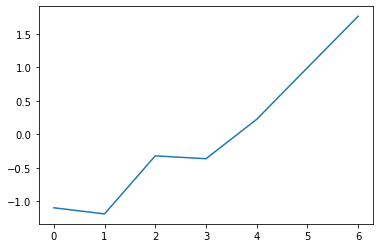

In [214]:
plt.plot(batch[0][1])

In [230]:
hidden_size = 6
import math
import torch
import torch.nn.functional as F

In [231]:
# For positional encoding
num_timescales = hidden_size // 2
max_timescale = 1000000.0
min_timescale = 1.0
log_timescale_increment = (
    math.log(float(max_timescale) / float(min_timescale)) /
    max(num_timescales - 1, 1))
inv_timescales = min_timescale * torch.exp(
    torch.arange(num_timescales, dtype=torch.float32) *
    -log_timescale_increment)





In [232]:

def get_position_encoding(x):
    max_length = x.shape[0]
    position = torch.arange(max_length, dtype=torch.float32,
                            device=x.device)
    scaled_time = position.unsqueeze(1) * inv_timescales.unsqueeze(0)
    signal = torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)],
                       dim=1)
    signal = F.pad(signal, (0, 0, 0, hidden_size % 2))
    signal = signal.view(1, max_length, hidden_size)
    return signal


In [233]:
x = batch[0][-3]

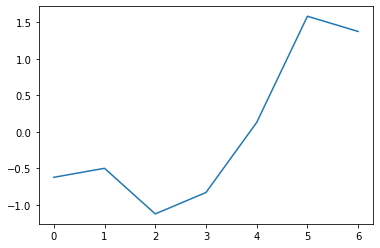

In [234]:
plt.plot(x)

In [235]:
get_position_encoding(x)

tensor([[[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00,
           1.0000e+00],
         [ 8.4147e-01,  1.0000e-03,  1.0000e-06,  5.4030e-01,  1.0000e+00,
           1.0000e+00],
         [ 9.0930e-01,  2.0000e-03,  2.0000e-06, -4.1615e-01,  1.0000e+00,
           1.0000e+00],
         [ 1.4112e-01,  3.0000e-03,  3.0000e-06, -9.8999e-01,  1.0000e+00,
           1.0000e+00],
         [-7.5680e-01,  4.0000e-03,  4.0000e-06, -6.5364e-01,  9.9999e-01,
           1.0000e+00],
         [-9.5892e-01,  5.0000e-03,  5.0000e-06,  2.8366e-01,  9.9999e-01,
           1.0000e+00],
         [-2.7942e-01,  6.0000e-03,  6.0000e-06,  9.6017e-01,  9.9998e-01,
           1.0000e+00]]])

In [236]:
get_position_encoding(batch[0][-1])[0]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00,
          1.0000e+00],
        [ 8.4147e-01,  1.0000e-03,  1.0000e-06,  5.4030e-01,  1.0000e+00,
          1.0000e+00],
        [ 9.0930e-01,  2.0000e-03,  2.0000e-06, -4.1615e-01,  1.0000e+00,
          1.0000e+00],
        [ 1.4112e-01,  3.0000e-03,  3.0000e-06, -9.8999e-01,  1.0000e+00,
          1.0000e+00],
        [-7.5680e-01,  4.0000e-03,  4.0000e-06, -6.5364e-01,  9.9999e-01,
          1.0000e+00],
        [-9.5892e-01,  5.0000e-03,  5.0000e-06,  2.8366e-01,  9.9999e-01,
          1.0000e+00],
        [-2.7942e-01,  6.0000e-03,  6.0000e-06,  9.6017e-01,  9.9998e-01,
          1.0000e+00]])

In [237]:
get_position_encoding(batch[0][0])[0]

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00,
          1.0000e+00],
        [ 8.4147e-01,  1.0000e-03,  1.0000e-06,  5.4030e-01,  1.0000e+00,
          1.0000e+00],
        [ 9.0930e-01,  2.0000e-03,  2.0000e-06, -4.1615e-01,  1.0000e+00,
          1.0000e+00],
        [ 1.4112e-01,  3.0000e-03,  3.0000e-06, -9.8999e-01,  1.0000e+00,
          1.0000e+00],
        [-7.5680e-01,  4.0000e-03,  4.0000e-06, -6.5364e-01,  9.9999e-01,
          1.0000e+00],
        [-9.5892e-01,  5.0000e-03,  5.0000e-06,  2.8366e-01,  9.9999e-01,
          1.0000e+00],
        [-2.7942e-01,  6.0000e-03,  6.0000e-06,  9.6017e-01,  9.9998e-01,
          1.0000e+00]])

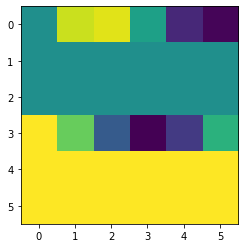

In [210]:
plt.imshow(get_position_encoding(batch[0][0])[0].T)

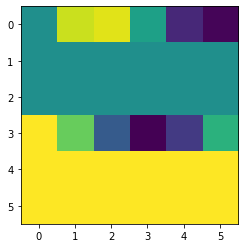

In [211]:
plt.imshow(get_position_encoding(batch[0][-1])[0].T)

In [275]:
from torch.nn import Embedding,Linear

In [276]:
embedding_layer = Linear(in_features=1,out_features=hidden_size,)

In [288]:
x = batch[0][0].unsqueeze(1)

In [289]:
x = embedding_layer(x).unsqueeze(0)
x += get_position_encoding(x)

In [303]:
x

tensor([[[ 0.9107, -1.1920,  1.4491,  0.0609,  1.4767,  0.5452],
         [ 0.7208, -1.0516,  1.1178,  0.2788,  1.3764,  0.6726],
         [ 0.6751, -1.0177,  1.0379,  0.3313,  1.3522,  0.7033],
         [ 0.3319, -0.7640,  0.4391,  0.7251,  1.1709,  0.9334],
         [ 0.0282, -0.5394, -0.0908,  1.0735,  1.0105,  1.1371],
         [-0.1860, -0.3810, -0.4647,  1.3194,  0.8972,  1.2808],
         [-0.4654, -0.1744, -0.9522,  1.6399,  0.7496,  1.4681]]],
       grad_fn=<AsStridedBackward>)

In [335]:
import torch.nn as nn
class DecoderLayer(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.self_attention_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.self_attention = MultiHeadAttention(hidden_size, dropout_rate)
        self.self_attention_dropout = nn.Dropout(dropout_rate)

       # self.enc_dec_attention_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        #self.enc_dec_attention = MultiHeadAttention(hidden_size, dropout_rate)
        #self.enc_dec_attention_dropout = nn.Dropout(dropout_rate)

        self.ffn_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.ffn = FeedForwardNetwork(hidden_size, filter_size, dropout_rate)
        self.ffn_dropout = nn.Dropout(dropout_rate)

    def forward(self, x, self_mask):
        y = self.self_attention_norm(x)
        y = self.self_attention(y, y, y, self_mask)
        y = self.self_attention_dropout(y)
        x = x + y

       # if enc_output is not None:
       #     y = self.enc_dec_attention_norm(x)
        #    y = self.enc_dec_attention(y, enc_output, enc_output, i_mask,
                                   #    cache)
          #  y = self.enc_dec_attention_dropout(y)
        #   x = x + y

        y = self.ffn_norm(x)
        y = self.ffn(y)
        y = self.ffn_dropout(y)
        x = x + y
        return x



class Decoder(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate, n_layers):
        super(Decoder, self).__init__()

        decoders = [DecoderLayer(hidden_size, filter_size, dropout_rate)
                    for _ in range(n_layers)]
        self.layers = nn.ModuleList(decoders)

        self.last_norm = nn.LayerNorm(hidden_size, eps=1e-6)

    def forward(self, x, self_mask):
        decoder_output = x
        for i, dec_layer in enumerate(self.layers):
            decoder_output = dec_layer(decoder_output,
                                       self_mask)
        return self.last_norm(decoder_output)

In [336]:
dec_layer = DecoderLayer(hidden_size, filter_size=3)

decoder = Decoder(hidden_size=6,filter_size=3,dropout_rate=.1,n_layers=8)

In [337]:
mask = torch.ones(1,7)
mask.shape

torch.Size([1, 7])

In [338]:
out = decoder.forward(x=x,self_mask=mask[0])

In [339]:
out.shape

torch.Size([1, 7, 6])

In [340]:
decoder

Decoder(
  (layers): ModuleList(
    (0): DecoderLayer(
      (self_attention_norm): LayerNorm((6,), eps=1e-06, elementwise_affine=True)
      (self_attention): MultiHeadAttention(
        (linear_q): Linear(in_features=6, out_features=6, bias=False)
        (linear_k): Linear(in_features=6, out_features=6, bias=False)
        (linear_v): Linear(in_features=6, out_features=6, bias=False)
        (att_dropout): Dropout(p=0.1, inplace=False)
        (output_layer): Linear(in_features=6, out_features=6, bias=False)
      )
      (self_attention_dropout): Dropout(p=0.1, inplace=False)
      (ffn_norm): LayerNorm((6,), eps=1e-06, elementwise_affine=True)
      (ffn): FeedForwardNetwork(
        (layer1): Linear(in_features=6, out_features=3, bias=True)
        (relu): ReLU()
        (dropout): Dropout(p=0.1, inplace=False)
        (layer2): Linear(in_features=3, out_features=6, bias=True)
      )
      (ffn_dropout): Dropout(p=0.1, inplace=False)
    )
    (1): DecoderLayer(
      (self_att

In [341]:
 sum(p.numel() for p in decoder.parameters() if p.requires_grad)

1716

# Putting it all together...

pasting the only used functions/classes and then doing a toy forward pass. 

In [2]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

def initialize_weight(x):
    nn.init.xavier_uniform_(x.weight)
    if x.bias is not None:
        nn.init.constant_(x.bias, 0)



class FeedForwardNetwork(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate,output_size=None):
        super(FeedForwardNetwork, self).__init__()

        self.layer1 = nn.Linear(hidden_size, filter_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        if output_size:
            self.layer2 = nn.Linear(filter_size, output_size)
        else:
            self.layer2 = nn.Linear(filter_size, hidden_size)

        initialize_weight(self.layer1)
        initialize_weight(self.layer2)

    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        return x


class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, dropout_rate, head_size=4):
        super(MultiHeadAttention, self).__init__()

        self.head_size = head_size

        self.att_size = att_size = hidden_size // head_size
        self.scale = att_size ** -0.5

        self.linear_q = nn.Linear(hidden_size, head_size * att_size, bias=False)
        self.linear_k = nn.Linear(hidden_size, head_size * att_size, bias=False)
        self.linear_v = nn.Linear(hidden_size, head_size * att_size, bias=False)
        initialize_weight(self.linear_q)
        initialize_weight(self.linear_k)
        initialize_weight(self.linear_v)

        self.att_dropout = nn.Dropout(dropout_rate)

        self.output_layer = nn.Linear(head_size * att_size, hidden_size,
                                      bias=False)
        initialize_weight(self.output_layer)

    def forward(self, q, k, v, mask, cache=None):
        orig_q_size = q.size()

        d_k = self.att_size
        d_v = self.att_size
        batch_size = q.size(0)

        # head_i = Attention(Q(W^Q)_i, K(W^K)_i, V(W^V)_i)
        q = self.linear_q(q).view(batch_size, -1, self.head_size, d_k)
        if cache is not None and 'encdec_k' in cache:
            k, v = cache['encdec_k'], cache['encdec_v']
        else:
            k = self.linear_k(k).view(batch_size, -1, self.head_size, d_k)
            v = self.linear_v(v).view(batch_size, -1, self.head_size, d_v)

            if cache is not None:
                cache['encdec_k'], cache['encdec_v'] = k, v

        q = q.transpose(1, 2)                  # [b, h, q_len, d_k]
        v = v.transpose(1, 2)                  # [b, h, v_len, d_v]
        k = k.transpose(1, 2).transpose(2, 3)  # [b, h, d_k, k_len]

        # Scaled Dot-Product Attention.
        # Attention(Q, K, V) = softmax((QK^T)/sqrt(d_k))V
        q.mul_(self.scale)
        x = torch.matmul(q, k)  # [b, h, q_len, k_len]
        #x.masked_fill_(mask.unsqueeze(1), -1e9)
        x = torch.softmax(x, dim=3)
        x = self.att_dropout(x)
        x = x.matmul(v)  # [b, h, q_len, attn]

        x = x.transpose(1, 2).contiguous()  # [b, q_len, h, attn]
        x = x.view(batch_size, -1, self.head_size * d_v)

        x = self.output_layer(x)

        assert x.size() == orig_q_size
        return x


    
class DecoderLayer(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()

        self.self_attention_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.self_attention = MultiHeadAttention(hidden_size, dropout_rate)
        self.self_attention_dropout = nn.Dropout(dropout_rate)

       # self.enc_dec_attention_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        #self.enc_dec_attention = MultiHeadAttention(hidden_size, dropout_rate)
        #self.enc_dec_attention_dropout = nn.Dropout(dropout_rate)

        self.ffn_norm = nn.LayerNorm(hidden_size, eps=1e-6)
        self.ffn = FeedForwardNetwork(hidden_size, filter_size, dropout_rate)
        self.ffn_dropout = nn.Dropout(dropout_rate)

    def forward(self, x, self_mask):
        y = self.self_attention_norm(x)
        y = self.self_attention(y, y, y, self_mask)
        y = self.self_attention_dropout(y)
        x = x + y

       # if enc_output is not None:
       #     y = self.enc_dec_attention_norm(x)
        #    y = self.enc_dec_attention(y, enc_output, enc_output, i_mask,
                                   #    cache)
          #  y = self.enc_dec_attention_dropout(y)
        #   x = x + y

        y = self.ffn_norm(x)
        y = self.ffn(y)
        y = self.ffn_dropout(y)
        x = x + y
        return x



class Decoder(nn.Module):
    def __init__(self, hidden_size, filter_size, dropout_rate, n_layers):
        super(Decoder, self).__init__()

        decoders = [DecoderLayer(hidden_size, filter_size, dropout_rate)
                    for _ in range(n_layers)]
        self.layers = nn.ModuleList(decoders)

        self.last_norm = nn.LayerNorm(hidden_size, eps=1e-6)

    def forward(self, x, self_mask):
        decoder_output = x
        for i, dec_layer in enumerate(self.layers):
            decoder_output = dec_layer(decoder_output,
                                       self_mask)
        return self.last_norm(decoder_output)
    
   



class Transformer(nn.Module):
    def __init__(self,
                 n_layers=6,
                 hidden_size=32,
                 filter_size=64,
                 dropout_rate=0.1,
                window_size=32):
        super(Transformer, self).__init__()
        
        self.window_size = window_size
        self.hidden_size = hidden_size
        self.emb_scale = hidden_size ** 0.5
        
        

        self.price_embedding = nn.Linear(window_size,hidden_size) # this 1 can be scaled to # of cryptos, trends, etc. Need to fix loaders as well for that but interesting opportunity. 
        
        nn.init.normal_(self.price_embedding.weight, mean=0,
                        std=hidden_size**-0.5)
        
        self.decoder = Decoder(hidden_size, filter_size,
                               dropout_rate, n_layers)
        
        self.output_mlp = FeedForwardNetwork(hidden_size,filter_size,dropout_rate,output_size=1) 


        # For positional encoding
        num_timescales = self.hidden_size // 2
        max_timescale = 10000.0
        min_timescale = 1.0
        log_timescale_increment = (
            math.log(float(max_timescale) / float(min_timescale)) /
            max(num_timescales - 1, 1))
        inv_timescales = min_timescale * torch.exp(
            torch.arange(num_timescales, dtype=torch.float32) *
            -log_timescale_increment)
        self.register_buffer('inv_timescales', inv_timescales)
        
        

    def forward(self, x):

        self_mask = create_self_mask(self.window_size)
        
        
        x = self.decode(x, self_mask)
        
        x = self.output_mlp(x[:,-1,:])
        return x


    def decode(self, x, self_mask):

        print(x.shape)
      #  x = self.price_embedding(x).unsqueeze(0)
      #  print(y.shape)
        #x = x[:,0] * torch.eye(self.window_size) # this does not convert to batch size 

     #   print(x.shape)
        x = torch.stack([x[i,:] * torch.eye(x.shape[1]) for i in range(x.shape[0])])
        #x = x.unsqueeze(0)
        print(x.shape)

        x *= self.emb_scale
        x += self.get_position_encoding(x)
      #  print(x.shape)
     #   target_embedded = self.t_emb_dropout(target_embedded)

        # decoder
        output = self.decoder(x, self_mask)

        return output # and take the last token of this.. 

    def get_position_encoding(self, x):
        max_length = x.size()[1]
        position = torch.arange(max_length, dtype=torch.float32,
                                device=x.device)
        scaled_time = position.unsqueeze(1) * self.inv_timescales.unsqueeze(0)
        signal = torch.cat([torch.sin(scaled_time), torch.cos(scaled_time)],
                           dim=1)
        signal = F.pad(signal, (0, 0, 0, self.hidden_size % 2))
        signal = signal.view(1, max_length, self.hidden_size)
        return signal


def create_self_mask(target_len, device=None):
    # Prevent leftward information flow in self-attention.
    ones = torch.ones(target_len, target_len, dtype=torch.uint8,
                      device=device)
    t_self_mask = torch.triu(ones, diagonal=1).unsqueeze(0)

    return t_self_mask

And what this all looks like, for the future model(s). 

In [4]:
import sys
sys.path.append('../src')
from dataloaders import create_dataloaders
import matplotlib.pyplot as plt
%matplotlib inline

train_loader, _, _ = create_dataloaders(prior_years=8,crypto='bitcoin',values='usd',batch_size=4,buy_thresh=3,labels_to_load=['pct_change'],window=14)

for batch in train_loader:
    break

In [101]:
model = Transformer(hidden_size=14,window_size=14)

In [102]:
x = batch[0]

In [103]:
batch[0].shape

torch.Size([4, 14])

In [104]:
out = model.forward( batch[0])

torch.Size([4, 14])
torch.Size([4, 14, 14])


In [106]:
out

tensor([[0.9707],
        [0.5785],
        [0.7585],
        [1.1213]], grad_fn=<AddmmBackward>)

Pass this output to a little NN, and the rest is history. That'll do. 

One thought is maybe make the hidden size larger that way days can more effectively occupy separate areas? or do we like the blending

nn.Embedding?
 to use this, I would need all possible integer values this price can take, which is a lot! Instead, we skip the lookup table and transform to a 
matrix